In [1]:
%matplotlib inline

In [2]:
from glob import glob

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from matplotlib import style
style.use('seaborn-notebook')

In [5]:
# l = !ls ../data/hourly_data_nc/

In [6]:
def make_title(station):
    name = geodata.ix[int(station)]['NOM_USUEL']
    lon = geodata.ix[int(station)]['LON_DG']
    lat = geodata.ix[int(station)]['LAT_DG']
    alt = geodata.ix[int(station)]['ALTI']
    title = "{}: [{:4.2f}E / {:4.2f}S], {:4.2f} m.".format(name, lon, lat, alt)
    return lat, lon, title

In [42]:
def harmo(data, nbharm=2): 
    import pandas as pd
    import numpy as np
    if isinstance(data, pd.core.frame.Series) or isinstance(data, pd.core.frame.DataFrame): 
        index = data.index
        data_values = data.values.flatten() 
    fft=np.fft.rfft(data_values)
    fft[nharm+1]=0.5*fft[nharm+1]
    fft[nharm+2:]=0
    data_f=np.fft.irfft(fft)
    if isinstance(data, pd.core.frame.Series): 
        data_f = pd.Series(data_f, index=index)
    if isinstance(data, pd.core.frame.DataFrame):
        data_f = pd.DataFrame(data_f, index=index, columns=['Fourier_{}harms'.format(nbharm)])
    return data_f

In [7]:
# for f in l: 
#     print("processing {}".format(f))
#     data = pd.read_csv('../data/hourly_data_nc/{}'.format(f), sep=';', \
#                        header=None, parse_dates = {'date': [1, 2, 3, 4]}, \
#                        index_col='date')
#     data.columns = ['station', 'rain', 'code']
#     data.to_csv('../data/{}.csv'.format(f[:-4]))
#     del(data)

In [8]:
geodata = pd.read_csv('../data/geo.csv', index_col=0, sep=';')

In [9]:
geodata[geodata.NOM_USUEL == 'NEPOUI']

,NOM_USUEL,LON_DG,LAT_DG,LAMBX_100,LAMBY_100,ALTI
NUM_POSTE,,,,,,
98827002,NEPOUI,165.002167,-21.318167,2964.85,3197.99,82


In [10]:
lfiles = glob('../data/98*.csv')

In [11]:
w = 6
h = 4 
res = 80

In [12]:
lfiles[-7]

'../data/98827002.csv'

In [13]:
!open ./98827002.png

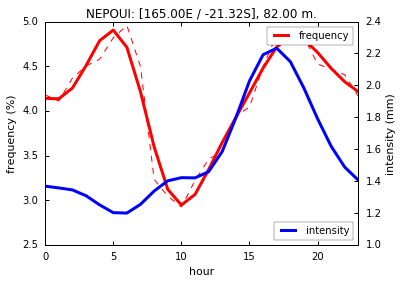

In [46]:
f = lfiles[-7]
station = f.split('/')[-1][:-4]
lat, lon, title = make_title(station)
data = pd.read_csv(f, parse_dates=True, engine='python', index_col='date')
datan = data.copy()
datan.replace({'rain': {0: np.nan}}, inplace=True)
# datan.dropna(inplace=True)
# rainfall frequency per hour (count of non-zero rainfall)
freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan.dropna()) * 100
freq_cycle_f = harmo(freq_cycle)
# rainfall average per hour
datann = datan.dropna()
mean_cycle = datann.groupby(datann.index.hour)[['rain']].mean()
mean_cycle_f = harmo(mean_cycle)
# plots
fig, ax1 = plt.subplots(figsize=(w,h))
fig.subplots_adjust(right=0.85)
ax2 = ax1.twinx()
ax1.plot(freq_cycle_f, 'r', label='frequency', lw=3)
ax2.plot(mean_cycle_f, 'b', label='intensity', lw=3)
ax1.plot(freq_cycle, 'r--', lw=1)
ax2.plot(mean_cycle_f, 'b--', lw=1)
ax1.legend()
ax2.legend(loc=4)
ax1.set_ylabel('frequency (%)')
ax2.set_ylabel('intensity (mm)')
ax1.set_xlim(0,23)
ax1.set_xlabel('hour')
ax1.set_title(title)
fig.savefig('./{}.png'.format(station), dpi=res)

In [25]:
isinstance(freq_cycle['rain'], pd.core.frame.Series)

True

In [24]:
freq_cycle

,rain
0,4.177999
1,4.110003
2,4.366878
3,4.502871
4,4.578422
5,4.820187
6,4.956180
7,4.495316
8,3.233605
9,3.044727


In [41]:
# %%writefile /Users/nicolasf/pythonlibs/time_utils/harmo.py
def harmo(data, nbharm=2): 
    import pandas as pd
    import numpy as np
    if isinstance(data, pd.core.frame.Series) or isinstance(data, pd.core.frame.DataFrame): 
        index = data.index
        data_values = data.values.flatten() 
    fft=np.fft.rfft(data_values)
    fft[nharm+1]=0.5*fft[nharm+1]
    fft[nharm+2:]=0
    data_f=np.fft.irfft(fft)
    if isinstance(data, pd.core.frame.Series): 
        data_f = pd.Series(data_f, index=index)
    if isinstance(data, pd.core.frame.DataFrame):
        data_f = pd.DataFrame(data_f, index=index, columns=['Fourier_{}harms'.format(nbharm)])
    return data_f

Writing /Users/nicolasf/pythonlibs/time_utils/harmo.py


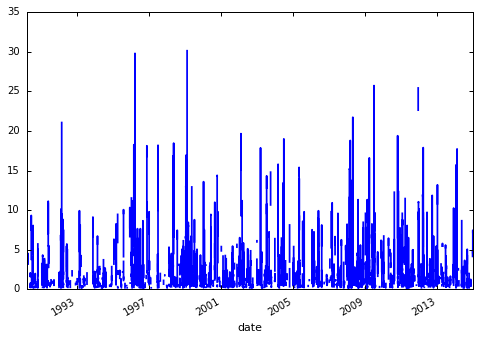

In [15]:
datan['rain'].pipe(pd.rolling_mean,3).plot()

In [16]:
freq_cycle = datan.groupby([datan.index.month, datan.index.hour])[['rain']].count()

In [17]:
mean_cycle = datan.groupby([datan.index.month, datan.index.hour])[['rain']].mean()

In [18]:
mean_cycler = pd.rolling_sum(data[['rain']], 3).groupby([datan.index.month, datan.index.hour])[['rain']].mean()

In [19]:
import seaborn as sns

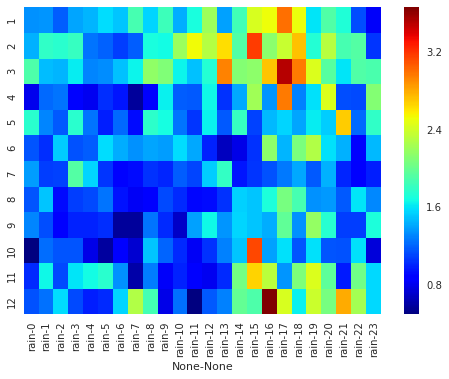

In [20]:
sns.heatmap(mean_cycle.unstack(), cmap=plt.get_cmap('jet'))

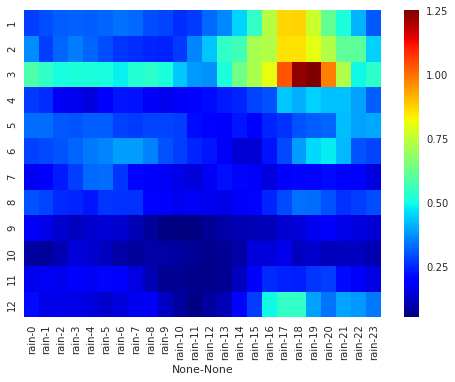

In [21]:
sns.heatmap(mean_cycler.unstack(), cmap=plt.get_cmap('jet'))

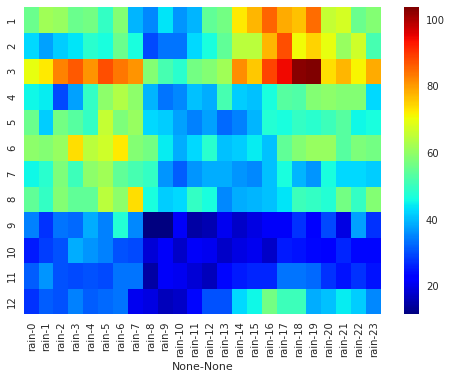

In [22]:
sns.heatmap(freq_cycle.unstack(), cmap=plt.get_cmap('jet'))

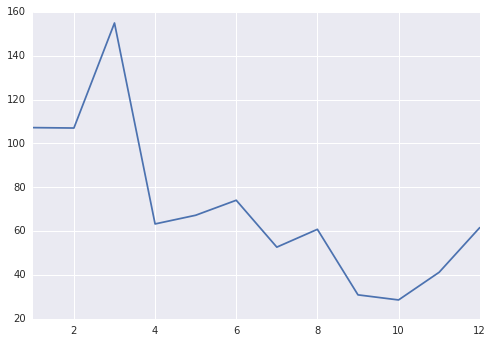

In [23]:
data_month = data.resample('1M',how='sum')
data_month.groupby(data_month.index.month)['rain'].mean().plot()

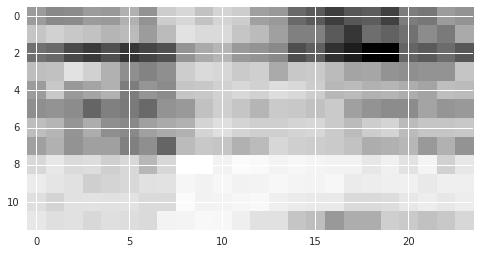

In [24]:
plt.imshow(freq_cycle.unstack().values, interpolation='nearest')

In [25]:
freq_cycle.unstack()

rain                                     ...                                \
     0   1   2   3   4   5   6   7   8   9  ...  14  15  16  17   18   19  20   
1    56  62  61  56  57  50  59  40  36  44 ...  73  78  86  79   77   85  66   
2    43  38  42  44  49  47  56  47  30  34 ...  65  65  78  88   71   75  70   
3    70  73  83  87  81  88  84  81  59  52 ...  82  76  89  95  103  104  74   
4    46  45  30  38  50  60  64  60  40  34 ...  42  41  47  54   53   59  60   
5    56  42  57  54  50  66  58  61  43  42 ...  35  40  48  47   50   49  51   
6    60  59  61  74  65  67  73  59  57  45 ...  42  45  41  55   59   61  61   
7    46  49  58  51  60  62  55  52  50  37 ...  37  36  41  47   40   37  47   
8    55  50  59  55  55  65  60  74  47  42 ...  39  40  41  44   51   50  48   
9    35  28  34  33  39  35  48  36  12  12 ...  18  20  22  22   28   23  30   
10   26  29  31  39  37  35  31  30  19  22 ...  20  21  18  26   25   24  23   
11   32  37  31  30  31  30  34  34  15  22 ...  26  27  27  34   34   33  28   
12   28  32  31  35  32  33  34  21  20  17 ...  43  46  57  51   51   39  41   

                
    21  22  23  
1   68  56  59  
2   61  67  52  
3   78  72  79  
4   59  59  43  
5   54  46  47  
6   54  58  57  
7   43  43  42  
8   57  50  59  
9   20  38  28  
10  27  24  24  
11  25  28  25  
12  45  42  36  

[12 rows x 24 columns]

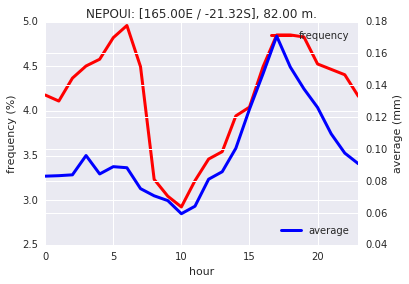

In [26]:
f = lfiles[-7]
station = f.split('/')[-1][:-4]
lat, lon, title = make_title(station)
data = pd.read_csv(f, parse_dates=True, engine='python', index_col='date')
datan = data.copy()
datan.replace({'rain': {0: np.nan}}, inplace=True)
# datan.dropna(inplace=True)
# rainfall frequency per hour (count of non-zero rainfall)
freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan.dropna()) * 100
# rainfall average per hour
# datann = datann.dropna()
mean_cycle = data.groupby(data.index.hour)[['rain']].mean()
# plots
fig, ax1 = plt.subplots(figsize=(w,h))
fig.subplots_adjust(right=0.85)
ax2 = ax1.twinx()
ax1.plot(freq_cycle, 'r', label='frequency', lw=3)
ax2.plot(mean_cycle, 'b', label='average', lw=3)
ax1.legend()
ax2.legend(loc=4)
ax1.set_ylabel('frequency (%)')
ax2.set_ylabel('average (mm)')
ax1.set_xlim(0,23)
ax1.set_xlabel('hour')
ax1.set_title(title)
fig.savefig('./{}.png'.format(station), dpi=res)

In [27]:
freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan.dropna()) * 100

In [28]:
freq_cycle.sum()

rain    100
dtype: float64

In [29]:
len(datan.dropna())

13236

In [30]:
data.quantile?

In [51]:
for f in lfiles: 
    station = f.split('/')[-1][:-4]
    lat, lon, title = make_title(station)
    data = pd.read_csv(f, parse_dates=True, engine='python', index_col='date')
    datan = data.copy()
    datan.replace({'rain': {0: np.nan}}, inplace=True)
    datan.dropna(inplace=True)
    
    freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan.dropna()) * 100
    freq_cycle_f = harmo(freq_cycle)
    # rainfall average per hour
    datann = datan.dropna()
    mean_cycle = datann.groupby(datann.index.hour)[['rain']].mean()
    mean_cycle_f = harmo(mean_cycle)
    # plots
    fig, ax1 = plt.subplots(figsize=(w,h))
    fig.subplots_adjust(right=0.85)
    ax2 = ax1.twinx()
    ax1.plot(freq_cycle_f, 'r', label='frequency', lw=3)
    ax2.plot(mean_cycle_f, 'b', label='intensity', lw=3)
    ax1.plot(freq_cycle, 'r--', lw=1)
    ax2.plot(mean_cycle, 'b--', lw=1)
    
    

    ax1.legend()
    ax2.legend(loc=4)
    ax1.set_ylabel('frequency')
    ax2.set_ylabel('average')
    ax1.set_xlim(0,23)
    ax1.set_xlabel('hour')
    ax1.set_title(title)
    fig.savefig('../www/{}.png'.format(station), dpi=res)
    plt.close(fig)

### maps

In [32]:
import folium
print (folium.__version__)

0.2.0


In [33]:
m = folium.Map(location=[-21, 166.4580], zoom_start=8, tiles='Mapbox', API_key='nicolasf.ic0ebom5')

In [34]:
# root_url = "https://cdn.rawgit.com/nicolasfauchereau/PLUVAR/master/www"
root_url = "https://raw.githubusercontent.com/nicolasfauchereau/PLUVAR/master/www"

In [35]:
# for f in lfiles: 
#     station = f.split('/')[-1][:-4]
#     fname = './{}.png'.format(station)
#     lat, lon, title = make_title(station)
    
#     html="""<img src='{}/{}.png'>""".format(root_url, station)
    
#     iframe = folium.element.IFrame(html=html, width=500, height=350)
    
#     popup = folium.Popup(iframe, max_width=600)

#     folium.Marker([lat, lon], popup=popup).add_to(m)

In [36]:
for f in lfiles: 
    station = f.split('/')[-1][:-4]
    
    lat, lon, title = make_title(station)
    
    html="""<img src='{}/{}.png'>""".format(root_url, station)
    
    iframe = folium.element.IFrame(html=html, width=500, height=350)
    
    popup = folium.Popup(iframe, max_width=600)
    
    c = folium.CircleMarker(location=[lat, lon], popup=popup, color='#FF0000', fill_color='#FF0000', fill_opacity=0.5, radius=2500)

    m.add_children(c)

In [37]:
m

In [38]:
m.save('../www/index.html')

In [39]:
m.save('../www/map.html')

In [52]:
!open ../www/